In [ ]:
query = """
SELECT *
FROM `stockprediction-434721.stock_data.meta_prices`
WHERE CAST(Date AS DATE) >= DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR)
"""

meta_df = client.query(query).to_dataframe()

In [ ]:
meta_df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2022-06-09 00:00:00+00:00,194.279999,199.449997,183.679993,184.00,183.622665,23501600,META
1,2022-02-09 00:00:00+00:00,224.199997,233.369995,222.210007,232.00,231.524231,86563300,META
2,2021-03-30 00:00:00+00:00,289.829987,292.470001,286.700012,288.00,287.409393,17474500,META
3,2020-04-16 00:00:00+00:00,177.949997,178.050003,172.509995,176.25,175.888565,23593200,META
4,2021-06-15 00:00:00+00:00,336.989990,339.920013,335.029999,336.75,336.059448,15795200,META
5,2020-06-15 00:00:00+00:00,225.089996,233.770004,224.800003,232.50,232.023209,15340300,META
6,2021-11-23 00:00:00+00:00,338.929993,341.399994,333.500000,337.25,336.558380,17225000,META
7,2021-03-15 00:00:00+00:00,269.079987,275.959991,268.500000,273.75,273.188629,16844800,META
8,2022-06-30 00:00:00+00:00,162.149994,165.229996,158.490005,161.25,160.919312,35250600,META
9,2023-03-03 00:00:00+00:00,178.919998,186.619995,177.050003,185.25,184.870102,45877700,META


**CLEANING AND PREPROCESSING:**

In [ ]:
# Check for any missing or null values
print(meta_df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64


In [ ]:
import pandas as pd
# Ensure that Date is in datetime format
meta_df['Date'] = pd.to_datetime(meta_df['Date'])

In [ ]:
# Drop columns that are not necessary for modeling
# Adjust this based on your needs
meta_df = meta_df.drop(columns=['Adj Close'])

In [ ]:
# Sort data by Date in ascending order
meta_df = meta_df.sort_values(by='Date', ascending=True)

In [ ]:
# Preview updated dataframes
print(meta_df.head())

                          Date        Open        High         Low  \
339  2019-09-16 00:00:00+00:00  186.929993  187.789993  185.770004   
528  2019-09-17 00:00:00+00:00  186.660004  188.320007  185.539993   
1169 2019-09-18 00:00:00+00:00  188.089996  189.080002  186.009995   
1189 2019-09-19 00:00:00+00:00  188.660004  191.100006  188.149994   
738  2019-09-20 00:00:00+00:00  190.660004  193.100006  188.119995   

           Close    Volume Ticker  
339   186.220001   8444800   META  
528   188.080002   9671100   META  
1169  188.139999   9681900   META  
1189  190.139999  10392700   META  
738   189.929993  19934200   META  


**FEATURE ENGINEERING:**

1. Create Rolling Features:
Moving Averages (e.g., 7-day, 30-day): These smooth out stock prices and reveal trends.
Volatility (Standard deviation of returns): Indicates stock price variability.
2. Create Lag Features:
Previous day's prices: Prices from a few days ago can help the model see short-term trends.
3. Compute Returns:
Daily returns: Percentage change from one day to the next.

In [ ]:
# Feature Engineering for meta

# 1. Moving Averages
meta_df['7_day_MA'] = meta_df['Close'].rolling(window=7).mean()
meta_df['30_day_MA'] = meta_df['Close'].rolling(window=30).mean()

# 2. Volatility (Standard deviation of daily returns over 7 and 30 days)
meta_df['7_day_volatility'] = meta_df['Close'].pct_change().rolling(window=7).std()
meta_df['30_day_volatility'] = meta_df['Close'].pct_change().rolling(window=30).std()

# 3. Lag Features (Previous day's price and volume)
meta_df['Previous_Close'] = meta_df['Close'].shift(1)
meta_df['Previous_Volume'] = meta_df['Volume'].shift(1)

# 4. Daily Returns
meta_df['Daily_Return'] = meta_df['Close'].pct_change()

# Preview updated dataframe for meta
print(meta_df.head())

                          Date        Open        High         Low  \
339  2019-09-16 00:00:00+00:00  186.929993  187.789993  185.770004   
528  2019-09-17 00:00:00+00:00  186.660004  188.320007  185.539993   
1169 2019-09-18 00:00:00+00:00  188.089996  189.080002  186.009995   
1189 2019-09-19 00:00:00+00:00  188.660004  191.100006  188.149994   
738  2019-09-20 00:00:00+00:00  190.660004  193.100006  188.119995   

           Close    Volume Ticker  7_day_MA  30_day_MA  7_day_volatility  \
339   186.220001   8444800   META       NaN        NaN               NaN   
528   188.080002   9671100   META       NaN        NaN               NaN   
1169  188.139999   9681900   META       NaN        NaN               NaN   
1189  190.139999  10392700   META       NaN        NaN               NaN   
738   189.929993  19934200   META       NaN        NaN               NaN   

      30_day_volatility  Previous_Close  Previous_Volume  Daily_Return  
339                 NaN             NaN          

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Ticker                0
7_day_MA              6
30_day_MA            29
7_day_volatility      7
30_day_volatility    30
Previous_Close        1
Previous_Volume       1
Daily_Return          1
dtype: int64


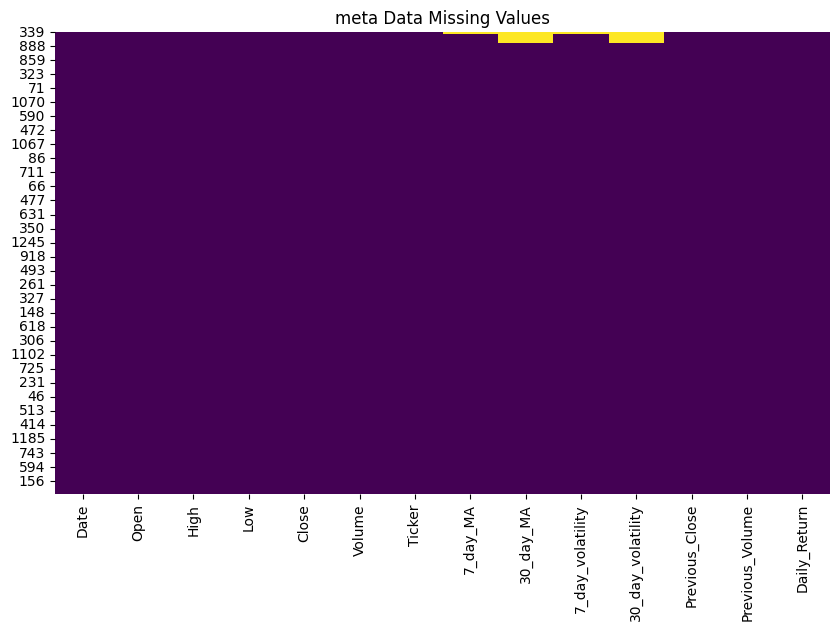

In [ ]:
# Check for missing values in each column for meta
print(meta_df.isna().sum())

# Visualize where NaNs occur in meta data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(meta_df.isna(), cbar=False, cmap="viridis")
plt.title('meta Data Missing Values')
plt.show()

Based on the heatmaps and summary, it looks like the missing values are indeed concentrated at the beginning of each dataset, particularly in the moving averages and volatility columns. Since these are rolling calculations, it's normal to see NaN values at the start.

It would be appropriate to drop the rows that contain these NaN values since they appear at the beginning and are not informative for future predictions.

In [ ]:
# Drop rows with NaN values in the meta dataframe
meta_df_cleaned = meta_df.dropna()

# Preview the cleaned meta dataframe
print(meta_df_cleaned.head())

                          Date        Open        High         Low  \
1023 2019-10-28 00:00:00+00:00  187.199997  189.529999  185.080002   
783  2019-10-29 00:00:00+00:00  191.690002  192.529999  188.470001   
33   2019-10-30 00:00:00+00:00  189.559998  190.449997  185.979996   
1041 2019-10-31 00:00:00+00:00  196.699997  198.089996  188.250000   
126  2019-11-01 00:00:00+00:00  192.850006  194.110001  189.910004   

           Close    Volume Ticker    7_day_MA   30_day_MA  7_day_volatility  \
1023  189.399994  13657900   META  186.824284  183.803334          0.022755   
783   189.309998  13574900   META  187.318569  183.844333          0.020349   
33    188.250000  28734600   META  187.102855  183.848000          0.018806   
1041  191.649994  42286500   META  188.432855  183.898333          0.009707   
126   193.619995  21711800   META  189.499998  184.021333          0.007860   

      30_day_volatility  Previous_Close  Previous_Volume  Daily_Return  
1023           0.016451      18

In [ ]:
print(meta_df_cleaned.shape)

(1221, 14)


Exporting to CSV to update BigQuery table:

In [ ]:
# Define the filename for the Meta dataframe
meta_csv_filename = "meta_cleaned_feature_engineered.csv"

# Export the cleaned Meta dataframe to CSV
meta_df_cleaned.to_csv(meta_csv_filename, index=False)

print(f"Dataframe exported to CSV: {meta_csv_filename}")

Dataframe exported to CSV: meta_cleaned_feature_engineered.csv


In [ ]:
from google.colab import files

# Download the Meta CSV file to your local machine
files.download('meta_cleaned_feature_engineered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**MODEL TRAINING:**

Step 1: Split the Data into Training and Testing Sets

* Training Set: 80% of the data, used to train the model.
* Testing Set: 20% of the data, used to evaluate the model's accuracy.

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X_meta = meta_df_cleaned[['7_day_MA', '30_day_MA', '7_day_volatility', '30_day_volatility', 'Previous_Close', 'Previous_Volume', 'Daily_Return']]
y_meta = meta_df_cleaned['Close']

# Split the data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

# Preview the shapes
print(X_train_meta.shape, X_test_meta.shape, y_train_meta.shape, y_test_meta.shape)

(976, 7) (245, 7) (976,) (245,)


Step 2: Select Machine Learning Models

* Start with Linear Regression for simplicity and benchmarking.
* Move to Random Forest or XGBoost to capture more complex patterns.
* Optionally, explore ARIMA or LSTM if you want a time-series-specific model.

**LINEAR REGRESSION MODEL:**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model_meta = LinearRegression()

# Train the model on the training data
model_meta.fit(X_train_meta, y_train_meta)

# Predict on the test data
y_pred_meta = model_meta.predict(X_test_meta)

# Evaluate the model
mse_meta = mean_squared_error(y_test_meta, y_pred_meta)
r2_meta = r2_score(y_test_meta, y_pred_meta)

print("meta Linear Regression Performance:")
print(f"Mean Squared Error: {mse_meta}")
print(f"R-squared: {r2_meta}")

meta Linear Regression Performance:
Mean Squared Error: 5.595268726973693
R-squared: 0.9994097795713779


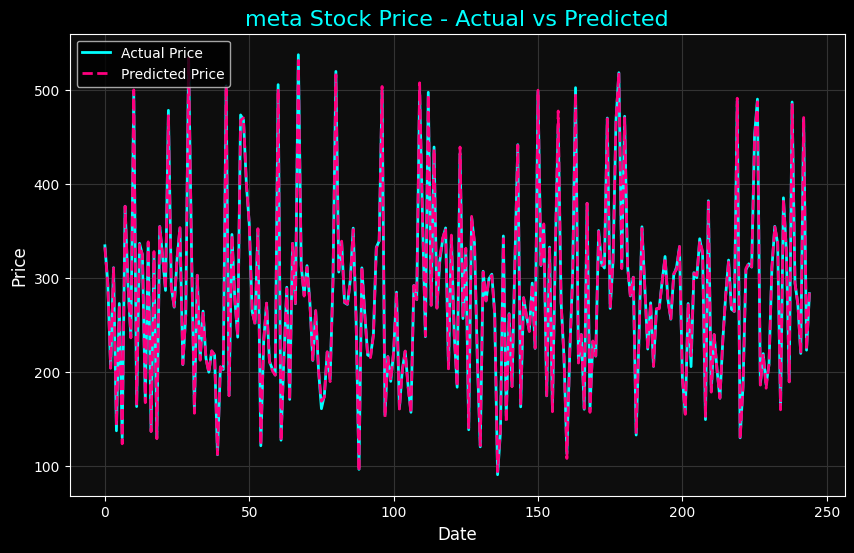

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the cyberpunk theme colors
cyberpunk_blue = '#00FFFF'
cyberpunk_red = '#FF007F'
cyberpunk_background = '#0D0D0D'

# Customize the plot style
plt.style.use('dark_background')

# Plot for meta stock
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test_meta)), y_test_meta, color=cyberpunk_blue, label='Actual Price', linewidth=2)
plt.plot(np.arange(len(y_pred_meta)), y_pred_meta, color=cyberpunk_red, linestyle='--', label='Predicted Price', linewidth=2)
plt.title('meta Stock Price - Actual vs Predicted', fontsize=16, color=cyberpunk_blue)
plt.xlabel('Date', fontsize=12, color='white')
plt.ylabel('Price', fontsize=12, color='white')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, color='#333333')
plt.gca().set_facecolor(cyberpunk_background)
plt.show()

**RANDOM FOREST MODEL:**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model for meta
rf_meta = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_meta.fit(X_train_meta, y_train_meta)

# Predict on the test data
y_pred_rf_meta = rf_meta.predict(X_test_meta)

# Evaluate the model
mse_rf_meta = mean_squared_error(y_test_meta, y_pred_rf_meta)
r2_rf_meta = r2_score(y_test_meta, y_pred_rf_meta)

print("meta Random Forest Performance:")
print(f"Mean Squared Error: {mse_rf_meta}")
print(f"R-squared: {r2_rf_meta}")

meta Random Forest Performance:
Mean Squared Error: 13.626392908303787
R-squared: 0.9985626114034272


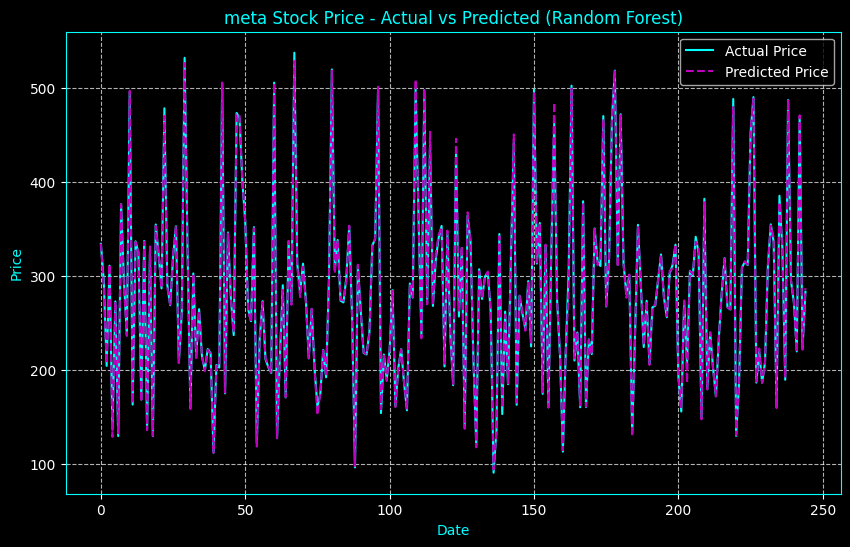

In [ ]:
# Visualization for Random Forest - meta
plt.figure(figsize=(10, 6))
plt.plot(y_test_meta[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_rf_meta[:250], 'm--', label="Predicted Price")
plt.title("meta Stock Price - Actual vs Predicted (Random Forest)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

FEATURE IMPORTANCE ANALYSIS:

explore which features (7-day MA, 30-day volatility, etc.) had the most influence on the stock price predictions.

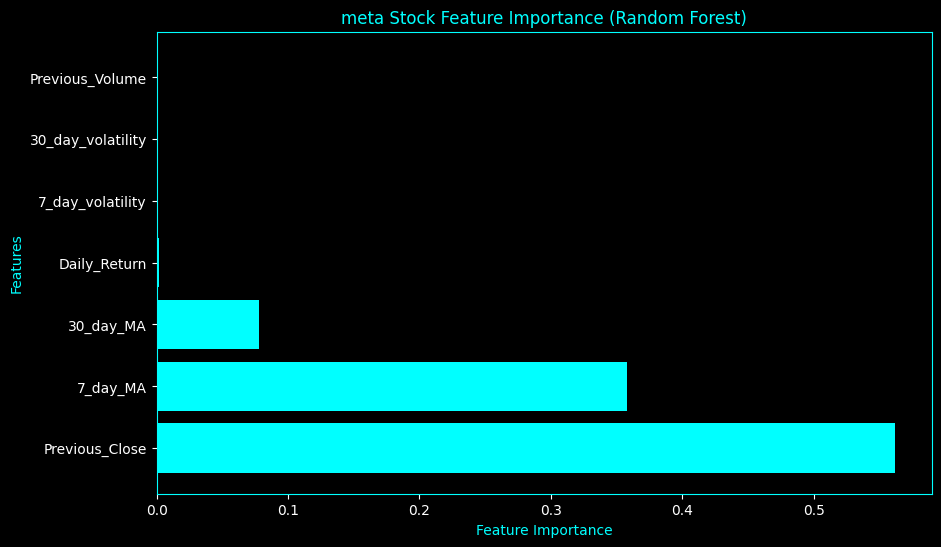

In [ ]:
# Get feature importance from the Random Forest model
importances_meta = rf_meta.feature_importances_

# Create a dataframe for the features and their importance
feature_names_meta = X_train_meta.columns
importance_df_meta = pd.DataFrame({
    'Feature': feature_names_meta,
    'Importance': importances_meta
})

# Sort the dataframe by importance
importance_df_meta = importance_df_meta.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_meta['Feature'], importance_df_meta['Importance'], color='cyan')
plt.xlabel('Feature Importance', color='cyan')
plt.ylabel('Features', color='cyan')
plt.title('meta Stock Feature Importance (Random Forest)', color='cyan')
plt.gca().set_facecolor('black')
plt.gca().spines['bottom'].set_color('cyan')
plt.gca().spines['top'].set_color('cyan')
plt.gca().spines['left'].set_color('cyan')
plt.gca().spines['right'].set_color('cyan')
plt.show()

**GRADIENT BOOSTING REGRESSOR:**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting model for meta
gb_meta = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
gb_meta.fit(X_train_meta, y_train_meta)

# Predict on the test data
y_pred_gb_meta = gb_meta.predict(X_test_meta)

# Evaluate the model
mse_gb_meta = mean_squared_error(y_test_meta, y_pred_gb_meta)
r2_gb_meta = r2_score(y_test_meta, y_pred_gb_meta)

print("meta Gradient Boosting Performance:")
print(f"Mean Squared Error: {mse_gb_meta}")
print(f"R-squared: {r2_gb_meta}")

meta Gradient Boosting Performance:
Mean Squared Error: 9.74746205654308
R-squared: 0.99897178285553


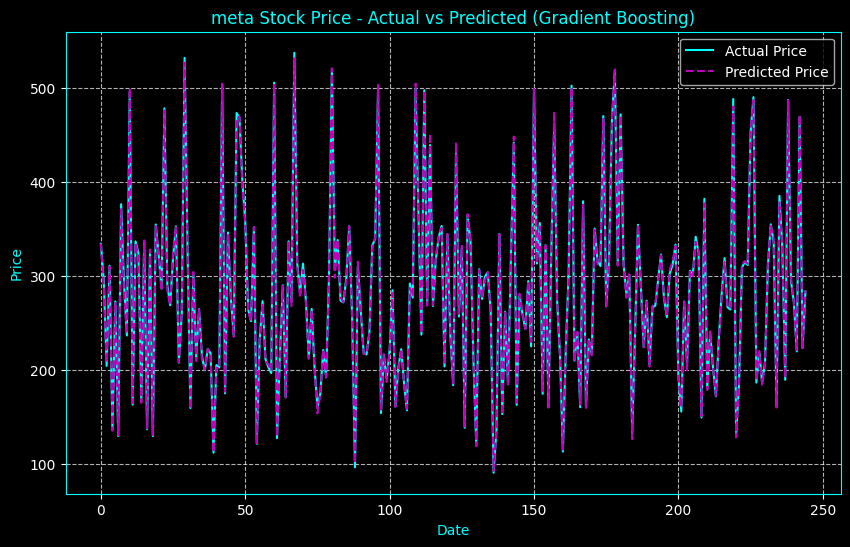

In [ ]:
# Visualization for Gradient Boosting - meta
plt.figure(figsize=(10, 6))
plt.plot(y_test_meta[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_gb_meta[:250], 'm--', label="Predicted Price")
plt.title("meta Stock Price - Actual vs Predicted (Gradient Boosting)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

HYPERPARAMTER TUNING:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
gb_meta = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_meta = GridSearchCV(estimator=gb_meta, param_grid=param_grid,
                                cv=5, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search_meta.fit(X_train_meta, y_train_meta)

# Get the best parameters
best_params_meta = grid_search_meta.best_params_
print("Best parameters for meta:", best_params_meta)

# Evaluate the model with the best parameters
best_gb_meta = grid_search_meta.best_estimator_
y_pred_meta = best_gb_meta.predict(X_test_meta)
mse_meta = mean_squared_error(y_test_meta, y_pred_meta)
r2_meta = r2_score(y_test_meta, y_pred_meta)

print(f"meta Gradient Boosting Performance (Tuned):")
print(f"Mean Squared Error: {mse_meta}")
print(f"R-squared: {r2_meta}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for meta: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
meta Gradient Boosting Performance (Tuned):
Mean Squared Error: 6.432226768944422
R-squared: 0.9993214925277387


the hyperparameter tuning for meta has finished successfully, and the best parameters have been found. The performance has improved with a lower mean squared error (MSE) after tuning.


SAVING THE TUNED MODEL:

In [ ]:
import joblib
joblib.dump(best_gb_meta, 'best_gb_meta_model.pkl')

['best_gb_meta_model.pkl']

**Long Short-Term Memory (LSTM) Neural Network for stock price prediction:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Feature scaling
scaler = StandardScaler()
X_train_meta_scaled = scaler.fit_transform(X_train_meta)
X_test_meta_scaled = scaler.transform(X_test_meta)

# Define the neural network model
model_meta = Sequential([
    Dense(64, input_dim=X_train_meta.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model_meta.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_meta = model_meta.fit(X_train_meta_scaled, y_train_meta, validation_split=0.2, epochs=50, batch_size=32)

# Predict on the test set
y_pred_nn_meta = model_meta.predict(X_test_meta_scaled)

# Evaluate the performance
mse_meta_nn = mean_squared_error(y_test_meta, y_pred_nn_meta)
r2_meta_nn = r2_score(y_test_meta, y_pred_nn_meta)

print(f"meta Neural Network Performance:")
print(f"Mean Squared Error: {mse_meta_nn}")
print(f"R-squared: {r2_meta_nn}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 87530.1875 - val_loss: 90179.1016
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89911.2656 - val_loss: 88511.7031
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 84588.5312 - val_loss: 85129.1406
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78304.5312 - val_loss: 79121.3281
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 76456.5703 - val_loss: 69760.7109
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 66129.3516 - val_loss: 57169.1367
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52509.0820 - val_loss: 42360.5586
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 38796.2891 - val_loss: 27527.8359
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24195.1055 - val_loss: 16844.4805
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15435.2842 - val_loss: 11054.2412
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10164.7881 - val_l

Notes:
You can adjust the number of neurons, layers, epochs, and batch size to optimize the model.
The StandardScaler ensures that all features are on the same scale, which is important for neural networks.
The models are trained for 50 epochs, but you can adjust the number of epochs based on the performance.


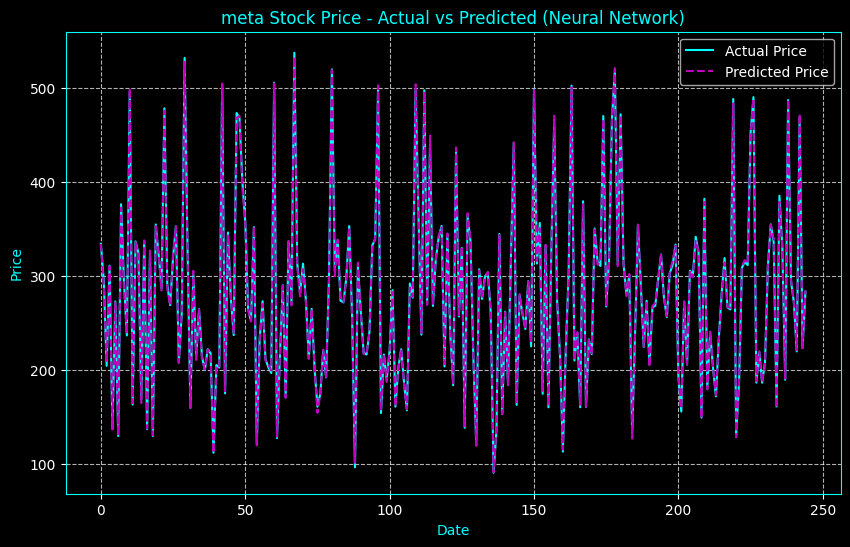

In [ ]:
# meta Neural Network Predictions Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test_meta[:250].values, color="cyan", label="Actual Price")
plt.plot(y_pred_meta[:250], 'm--', label="Predicted Price")
plt.title("meta Stock Price - Actual vs Predicted (Neural Network)", color="cyan")
plt.xlabel("Date", color="cyan")
plt.ylabel("Price", color="cyan")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().set_facecolor("black")
plt.gca().spines["bottom"].set_color("cyan")
plt.gca().spines["top"].set_color("cyan")
plt.gca().spines["left"].set_color("cyan")
plt.gca().spines["right"].set_color("cyan")
plt.show()

In [ ]:
# Save the Neural Network model for meta in the native Keras format
model_meta.save('best_nn_meta_model_tuned.keras')

In [ ]:
joblib.dump(model_meta, 'linear_reg_meta_model.pkl')

['linear_reg_meta_model.pkl']

In [ ]:
joblib.dump(rf_meta, 'random_forest_meta_model.pkl')

['random_forest_meta_model.pkl']

In [ ]:
joblib.dump(best_gb_meta, 'gradient_boost_meta_model.pkl')

['gradient_boost_meta_model.pkl']

In [ ]:
# Load all Models for meta:

from tensorflow.keras.models import load_model

# Load Linear Regression model
linear_reg_meta_model = joblib.load('linear_reg_meta_model.pkl')

# Load Random Forest model
random_forest_meta_model = joblib.load('random_forest_meta_model.pkl')

# Load Gradient Boosting model
gradient_boost_meta_model = joblib.load('gradient_boost_meta_model.pkl')

# Load Neural Network model for meta
best_nn_meta_model = load_model('best_nn_meta_model_tuned.keras')

In [ ]:
from google.colab import files

# Download the saved models to your local machine
files.download('linear_reg_meta_model.pkl')
files.download('random_forest_meta_model.pkl')
files.download('gradient_boost_meta_model.pkl')
files.download('best_nn_meta_model_tuned.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Dashboard:**

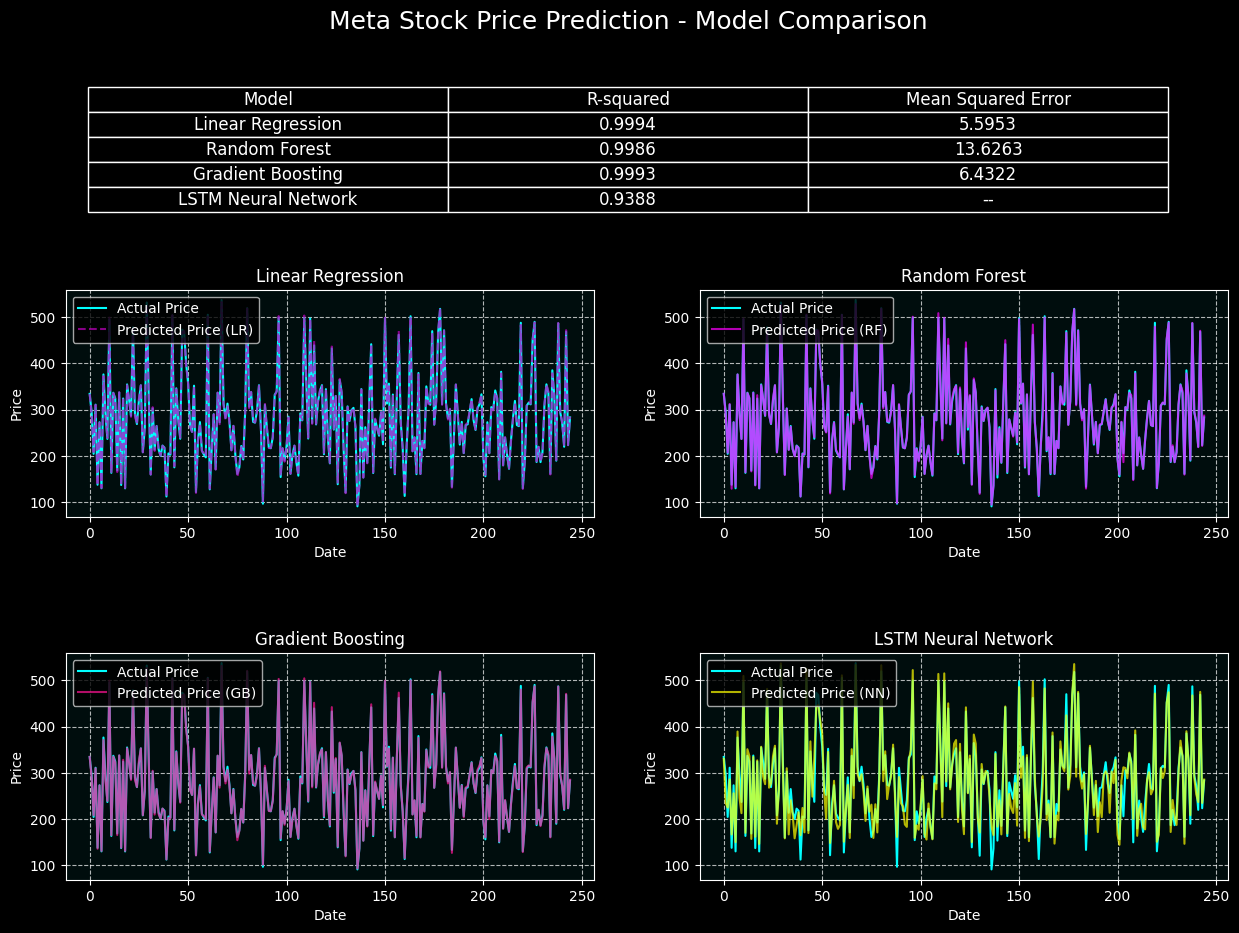

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors
cyberpunk_blue = '#00FFFF'
cyberpunk_pink = '#FF1493'  # Pink color for Gradient Boosting
cyberpunk_background = '#000D0D'
random_forest_color = '#FF00FF'  # Magenta for Random Forest
lstm_color = '#FFFF00'  # Yellow for LSTM

# Create subplots: 2 rows, 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.6, top=0.70)  # Adjusting space between the charts and shifting top margin for title

# Title for the entire figure
fig.suptitle('Meta Stock Price Prediction - Model Comparison', fontsize=18, color='white')

# Table with model performance metrics
table_data = [
    ["Model", "R-squared", "Mean Squared Error"],
    ["Linear Regression", round(0.9994, 4), round(5.5953, 4)],
    ["Random Forest", round(0.9986, 4), round(13.6263, 4)],
    ["Gradient Boosting", round(0.9993, 4), round(6.4322, 4)],
    ["LSTM Neural Network", round(0.9388, 4), "--"]  # Replacing the LSTM MSE with "--"
]

# Add the table without extra space
ax_table = fig.add_axes([0.1, 0.78, 0.8, 0.12])  # Shifting the table slightly lower
ax_table.axis('off')
table = ax_table.table(cellText=table_data, colWidths=[0.3]*3, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Set table background to black and text to white
for key, cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_text_props(color='white')
    cell.set_facecolor('black')

# Plot 1: Linear Regression
axs[0, 0].plot(np.arange(len(y_test_meta[:250])), y_test_meta[:250], color=cyberpunk_blue, label='Actual Price')
axs[0, 0].plot(np.arange(len(y_pred_meta[:250])), y_pred_meta[:250], 'm--', label='Predicted Price (LR)', alpha=0.7)
axs[0, 0].set_title('Linear Regression', fontsize=12, color='white')
axs[0, 0].set_xlabel('Date', fontsize=10, color='white')
axs[0, 0].set_ylabel('Price', fontsize=10, color='white')
axs[0, 0].legend(loc='upper left')
axs[0, 0].grid(True, linestyle='--', alpha=0.7)
axs[0, 0].set_facecolor(cyberpunk_background)

# Plot 2: Random Forest (Magenta)
axs[0, 1].plot(np.arange(len(y_test_meta[:250])), y_test_meta[:250], color=cyberpunk_blue, label='Actual Price')
axs[0, 1].plot(np.arange(len(y_pred_rf_meta[:250])), y_pred_rf_meta[:250], color=random_forest_color, label='Predicted Price (RF)', alpha=0.7)
axs[0, 1].set_title('Random Forest', fontsize=12, color='white')
axs[0, 1].set_xlabel('Date', fontsize=10, color='white')
axs[0, 1].set_ylabel('Price', fontsize=10, color='white')
axs[0, 1].legend(loc='upper left')
axs[0, 1].grid(True, linestyle='--', alpha=0.7)
axs[0, 1].set_facecolor(cyberpunk_background)

# Plot 3: Gradient Boosting (Pink)
axs[1, 0].plot(np.arange(len(y_test_meta[:250])), y_test_meta[:250], color=cyberpunk_blue, label='Actual Price')
axs[1, 0].plot(np.arange(len(y_pred_gb_meta[:250])), y_pred_gb_meta[:250], color=cyberpunk_pink, label='Predicted Price (GB)', alpha=0.7)  # Pink color
axs[1, 0].set_title('Gradient Boosting', fontsize=12, color='white')
axs[1, 0].set_xlabel('Date', fontsize=10, color='white')
axs[1, 0].set_ylabel('Price', fontsize=10, color='white')
axs[1, 0].legend(loc='upper left')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)
axs[1, 0].set_facecolor(cyberpunk_background)

# Plot 4: LSTM Neural Network (Yellow)
axs[1, 1].plot(np.arange(len(y_test_meta[:250])), y_test_meta[:250], color=cyberpunk_blue, label='Actual Price')
axs[1, 1].plot(np.arange(len(y_pred_nn_meta[:250])), y_pred_nn_meta[:250], color=lstm_color, label='Predicted Price (NN)', alpha=0.7)
axs[1, 1].set_title('LSTM Neural Network', fontsize=12, color='white')
axs[1, 1].set_xlabel('Date', fontsize=10, color='white')
axs[1, 1].set_ylabel('Price', fontsize=10, color='white')
axs[1, 1].legend(loc='upper left')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)
axs[1, 1].set_facecolor(cyberpunk_background)

# Display the final dashboard
plt.show()